In [ ]:
# HYPER PARAMETERS

SPLIT = [0.6, 0.2, 0.2] # train / validation / test
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 10
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

In [ ]:
from os import listdir
from os.path import isfile, join
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
# Data Exploration

In [ ]:
drive.mount('/content/drive')
mainPath = '/content/drive/My Drive/celebData/'
baldPath = mainPath + 'BigBald/'
hairPath = mainPath + 'BigHair/'

baldFiles = [f for f in listdir(baldPath) if isfile(join(baldPath, f))]
hairFiles = [f for f in listdir(hairPath) if isfile(join(hairPath, f))]

EXAMPLE_PIC = hairPath + hairFiles[0]

# print(hairFiles)
# print(baldFiles)

X = []
y = []
for i in baldFiles:
  X.append(i)
  y.append(1)
for i in hairFiles:
  X.append(i)
  y.append(0)

print(len(X))

Mounted at /content/drive


157148.jpg


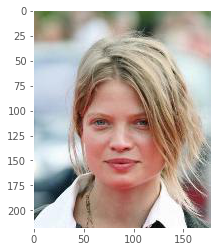

In [6]:
print(EXAMPLE_PIC.split('/')[-1])
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)

In [ ]:
# 2) splitting data / we're not going to use their partitioning, we'll make our own

In [7]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

In [8]:
def generate_df(X, y):
  x_ = []
  y_ = []
  for i in range(len(X)):
    if(i%100 == 0):
      print(i)
    filePath = ""
    if(y[i]==0):
      filePath = hairPath
    else:
      filePath = baldPath
    im = cv2.imread(filePath + X[i])
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    x_.append(im)
    y_.append(y[i])
  x_ = np.array(x_)
  x_ = x_.reshape(x_.shape[0], 218, 178, 3)
  y_ = np_utils.to_categorical(y_,2)
  return x_, y_

In [ ]:
# 3) Data augmentation

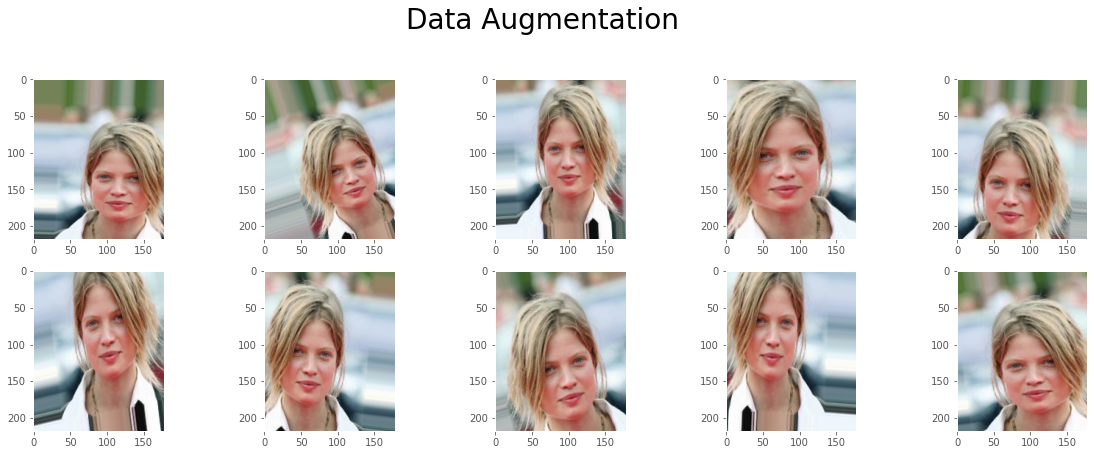

In [9]:
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [10]:
split2Ratio = SPLIT[2] / (SPLIT[1] + SPLIT[2])

X_trainL, X_testL2, y_trainL, y_testL2 = train_test_split(X, y, train_size=SPLIT[0], random_state=0, shuffle=True, stratify=y)
X_testL, X_valL, y_testL, y_valL = train_test_split(X_testL2, y_testL2, test_size=split2Ratio, random_state=0, shuffle=True, stratify=y_testL2)

print(np.shape(X_trainL), np.shape(X_valL) ,np.shape(X_testL))

(5449,) (1817,) (1816,)


056871.jpg hair


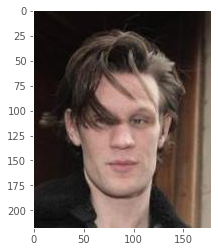

In [11]:
import random
i = int(random.random()*len(X_valL))
tag = ""
filePath = ""
if(y_valL[i]==0):
  filePath = hairPath
  tag = "hair"
else:
  filePath = baldPath
  tag = "bald"
print(X_valL[i], tag)
img = load_img(filePath + X_valL[i])
plt.grid(False)
plt.imshow(img)

In [12]:
# Training data
# x_train, y_train = generate_df(df_attr2, X_trainL)
x_train, y_train = generate_df(X_trainL, y_trainL)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400


In [13]:
print(np.shape(x_train))
print(np.shape(y_train))

(5449, 218, 178, 3)
(5449, 2)


In [14]:
# count to see if training as balance of labels

c1 = 0
c2 = 0
for i in y_train:
  if i[0] == 1:
    c1+=1
  if i[1] == 1:
    c2+=1
print(c1, c2, c1+c2)

2721 2728 5449


In [15]:
train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [16]:
#Validation Data
x_valid, y_valid = generate_df(X_valL, y_valL)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [17]:
print(np.shape(x_valid))
print(np.shape(y_valid))

c1 = 0
c2 = 0
for i in y_valid:
  if i[0] == 1:
    c1+=1
  if i[1] == 1:
    c2+=1
print(c1, c2, c1+c2)

(1817, 218, 178, 3)
(1817, 2)
907 910 1817


In [ ]:
# 4) Build and Train Model

In [18]:
# Import InceptionV3 Model
# path to weights: '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

# add custom layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.bald.hdf5', 
                               verbose=1, save_best_only=True)

87924736/87910968 [==============================] - 0s 0us/step
number of layers: 311


In [19]:
# train model
print(len(x_train))
print(BATCH_SIZE)
step = (len(x_train)) / (BATCH_SIZE)
print(step)
hist = model_.fit(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= step
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

5449
10
544.9
Epoch 1/20
545/544 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.6089
Epoch 1: val_loss improved from inf to 0.71084, saving model to weights.best.inc.bald.hdf5
544/544 [==============================] - 96s 145ms/step - loss: 0.6586 - accuracy: 0.6089 - val_loss: 0.7108 - val_accuracy: 0.5597
Epoch 2/20
545/544 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7629
Epoch 2: val_loss improved from 0.71084 to 0.61863, saving model to weights.best.inc.bald.hdf5
544/544 [==============================] - 62s 113ms/step - loss: 0.4900 - accuracy: 0.7629 - val_loss: 0.6186 - val_accuracy: 0.6560
Epoch 3/20
545/544 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8416
Epoch 3: val_loss did not improve from 0.61863
544/544 [==============================] - 61s 112ms/step - loss: 0.3604 - accuracy: 0.8416 - val_loss: 0.7794 - val_accuracy: 0.5570
Epoch 4/20
545/544 [==============================] - ETA: 0s -

In [20]:
model_.save('256_50_128_Weights.hdf5')

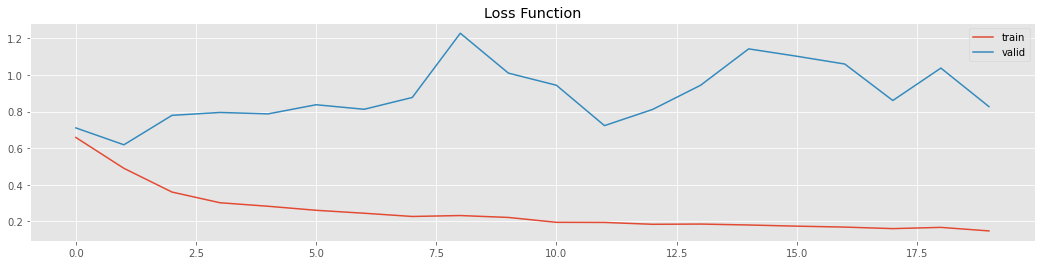

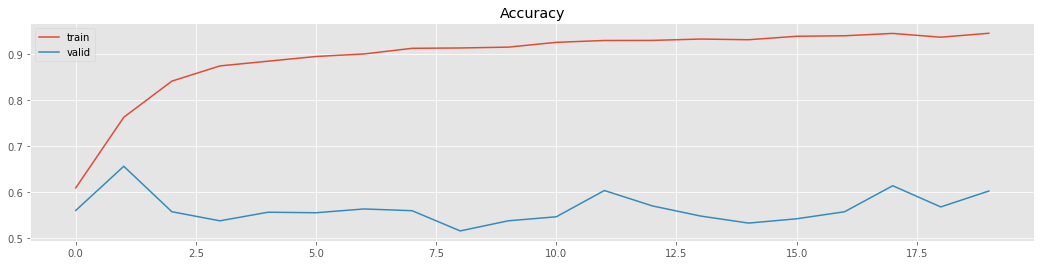

In [21]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
# model eval

In [23]:
def generate_df_test(X, y):
  x_ = []
  y_ = []
  for i in range(len(X)):
    filePath = ""
    if(y[i]==0):
      filePath = hairPath
    else:
      filePath = baldPath
    im = cv2.imread(filePath + X[i])
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    x_.append(im)
    y_.append(y[i])
  return x_, y_

In [24]:
# load weights
model_.load_weights('weights.best.inc.bald.hdf5')

# Test Data
x_test, y_test = generate_df_test(X_testL, y_testL)

# generate prediction
model_predictions = [ np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 64.2621%
f1_score: 0.5483646485734169


In [ ]:
gender_target = {0: 'Hair'
                , 1: 'Bald'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Hair'
        
    if prediction[1] > 0.5:
        gender = 'Bald'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))
  
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

In [ ]:
# select random images of the test partition
model_.load_weights('finalEpochWeights.hdf5')


files = X_trainL
label = y_trainL

for k in range(10):
  i = int(random.random()*len(files))
  filePath = ""
  if(label[i]==0):
    filePath = hairPath
  else:
    filePath = baldPath
  imgPath = filePath + files[i]
  result = gender_prediction(imgPath)
  display_result(imgPath, result[0], label[i])


# df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

# for index, target in df_to_test.iterrows():
#     result = gender_prediction(images_folder + index)
    
#     #display result
#     display_result(images_folder + index, result[0], target['Male'])